# 🔹 Step 1: Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

2026-01-14 16:15:09.310428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768407309.500737      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768407309.554697      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768407309.981363      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768407309.981399      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768407309.981402      55 computation_placer.cc:177] computation placer alr

# 🔹 Step 2: Dataset Path

In [2]:
DATASET_DIR = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES"

IMG_SIZE = 224
BATCH_SIZE = 32

# 🔹 Step 3: Train / Validation Split

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.85, 1.15],
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

NUM_CLASSES = train_data.num_classes

Found 21726 images belonging to 10 classes.
Found 5427 images belonging to 10 classes.


# 🔹 Step 4. Handle Class Imbalance

In [4]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights = dict(enumerate(class_weights))


# 🔹 Step 5: Custom CNN Model (From Scratch)

In [5]:
model = Sequential([

    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.6),

    Dense(NUM_CLASSES, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1768407343.252296      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# 🔹 Step 6: Compile Model

In [6]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss=loss_fn,
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,411,658 (28.27 MB)

 Trainable params: 7,409,162 (28.26 MB)

 Non-trainable params: 2,496 (9.75 KB)

# 🔹 Step 7. Smart Callbacks

In [7]:
callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3, min_lr=1e-6)
]

# 🔹 Step 8: Train Model

In [8]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1768407351.116253     134 service.cc:152] XLA service 0x7c1dac006900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768407351.116290     134 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768407351.889413     134 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/679 ━━━━━━━━━━━━━━━━━━━━ 2:16:49 12s/step - accuracy: 0.0312 - loss: 4.3017

I0000 00:00:1768407358.674390     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


679/679 ━━━━━━━━━━━━━━━━━━━━ 661s 957ms/step - accuracy: 0.3702 - loss: 2.6176 - val_accuracy: 0.2187 - val_loss: 4.2298 - learning_rate: 3.0000e-04
Epoch 2/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 424s 624ms/step - accuracy: 0.4807 - loss: 1.8732 - val_accuracy: 0.2948 - val_loss: 2.5808 - learning_rate: 3.0000e-04
Epoch 3/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 417s 614ms/step - accuracy: 0.5232 - loss: 1.7148 - val_accuracy: 0.3459 - val_loss: 2.0066 - learning_rate: 3.0000e-04
Epoch 4/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 426s 628ms/step - accuracy: 0.5584 - loss: 1.6153 - val_accuracy: 0.3193 - val_loss: 1.9755 - learning_rate: 3.0000e-04
Epoch 5/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 423s 623ms/step - accuracy: 0.5935 - loss: 1.5395 - val_accuracy: 0.3324 - val_loss: 2.1021 - learning_rate: 3.0000e-04
Epoch 6/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 420s 618ms/step - accuracy: 0.6077 - loss: 1.4928 - val_accuracy: 0.3276 - val_loss: 2.2715 - learning_rate: 3.0000e-04
Epoch 7/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 420s 618ms/

# 🔹 Step 9: Evaluation

In [9]:
loss, acc = model.evaluate(val_data)
print(f"Validation Accuracy: {acc*100:.2f}%")

170/170 ━━━━━━━━━━━━━━━━━━━━ 79s 463ms/step - accuracy: 0.4238 - loss: 1.8023
Validation Accuracy: 42.36%


# 🔹 Step 10: Training Graphs

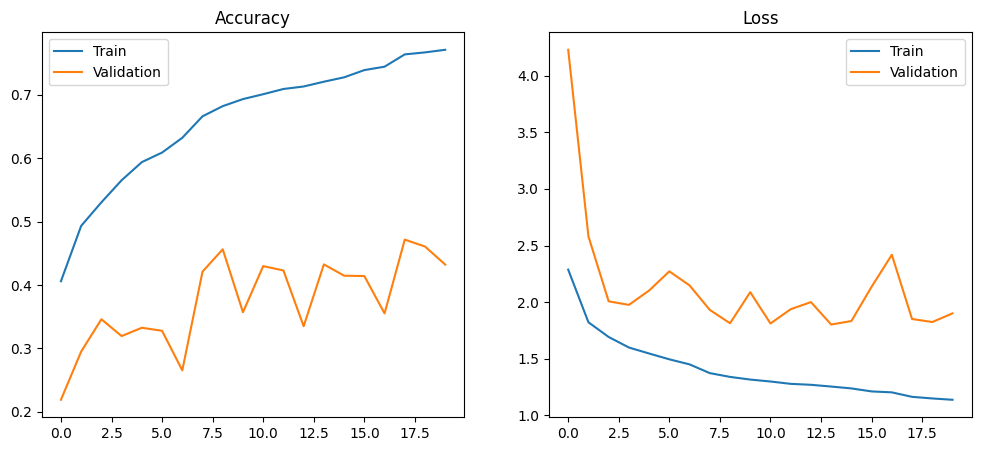

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.show()


# 🔹 Step 11: Save Model

In [11]:
model.save("skin_disease_custom_cnn.h5")
print("Model saved successfully")


Model saved successfully
